In [2]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [3]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


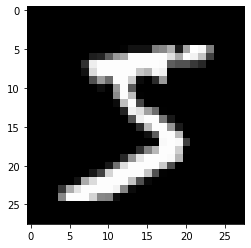

In [4]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

In [12]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)

print(y_train.unique())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


<ipython-input-12-e66d6e52f856>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train, y_train, x_valid, y_valid = map(


## NN from scratch

1) Define tensors of random numbers that will become the parameters of the models.
Indicate that those tensors need a Gradient.
Use of Xavier init.

Any parameter used in a model must have the property requires_grad=True in order to update its values with backprop.

In [14]:
import math
weights = torch.randn(784, 10) / math.sqrt(784) # Xavier init
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

Defining model and activation function

The model is just the output layer.

Log softmax (for numerical stability):
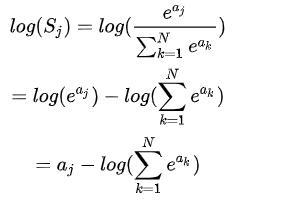

In [15]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias) # @ is the dot product, or matrix multiplication

Define batches and test the untrained model

In [16]:
bs=64
xb = x_train[:bs]
preds = model(xb)
print(preds[0], preds.shape)

tensor([-2.4346, -2.5940, -2.4532, -2.0867, -2.3570, -2.2547, -2.0253, -2.6464,
        -2.4255, -1.9906], grad_fn=<SelectBackward>) torch.Size([64, 10])


Define the negative log likelihood loss function

Return the (negative) value of the target index. Doing so, during training the correct targets is the one with value 0.

On the differences between negative log likelihood, cross entropy loss and KL divergence https://glassboxmedicine.com/2019/12/07/connections-log-likelihood-cross-entropy-kl-divergence-logistic-regression-and-neural-networks/]
Spoiler: They can be the same but their origin has different interpretations

In [20]:
def nll(input, target):
    return - input[range(target.shape[0]), target].mean()

In [21]:
loss_func = nll

In [22]:
yb = y_train[:bs]
print(loss_func(preds, yb))

tensor(2.3346, grad_fn=<NegBackward>)


In [28]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1) # Take the index of the greatest value
    return (preds==yb).float().mean()

In [30]:
print(accuracy(preds,yb))

tensor(0.0938)


### Creating the training loop

1) Select minibatch
2) Do predictions
3) Compute loss
4) Update the parameters of the model through loss.backward, computing the gradient.

It is necessary to use the torch.no_grad() context manager in order to no record the gradients computations for the next steps of the tutorial.

We then set the gradients to zero, so that we are ready for the next loop. Otherwise, our gradients would record a running tally of all the operations that had happened (i.e. loss.backward() adds the gradients to whatever is already stored, rather than replacing them).

In [40]:
from IPython.core.debugger import set_trace

lr = 0.5  # learning rate
epochs = 5  # how many epochs to train for

for epoch in range(epochs): # epoch = 1 pass through all the data
    print(f"Epoch: {epoch}")
    for i in range((n - 1) // bs + 1): # divide the data in batches
        #         set_trace()
        start_i = i * bs # first index actual batch
        end_i = start_i + bs # last index actual batch
        xb = x_train[start_i:end_i] # taking the batch features
        yb = y_train[start_i:end_i] # taking the batch targets
        pred = model(xb) # predict
        loss = loss_func(pred, yb) # compute loss

        loss.backward() # backpropagate the loss
        with torch.no_grad(): # deactivate gradient recording as it is no needed in the following computations
            weights -= weights.grad * lr # update weights
            bias -= bias.grad * lr # update biases
            weights.grad.zero_() # reset gradients to zero in order to not accumulate
            bias.grad.zero_() # reset gradients to zero
    print(loss_func(model(xb), yb), accuracy(model(xb), yb))

Epoch: 0
tensor(0.0507, grad_fn=<NegBackward>) tensor(1.)
Epoch: 1
tensor(0.0504, grad_fn=<NegBackward>) tensor(1.)
Epoch: 2
tensor(0.0502, grad_fn=<NegBackward>) tensor(1.)
Epoch: 3
tensor(0.0500, grad_fn=<NegBackward>) tensor(1.)
Epoch: 4
tensor(0.0497, grad_fn=<NegBackward>) tensor(1.)


In [41]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0497, grad_fn=<NegBackward>) tensor(1.)


In [49]:
yb

tensor([9, 3, 7, 0, 9, 0, 8, 5, 5, 2, 4, 5, 0, 8, 4, 8])

In [48]:
model(xb)[range(yb.shape[0])].round()

tensor([[-17., -21., -14., -15.,  -7., -15., -14.,  -9.,  -6.,  -0.],
        [ -6., -13.,  -2.,  -0., -18.,  -5.,  -4., -16.,  -4., -15.],
        [-23., -17., -16.,  -9., -16., -15., -25.,  -0., -13.,  -5.],
        [ -0., -16.,  -5.,  -3., -12.,  -5.,  -3., -11.,  -7.,  -9.],
        [-12., -24., -10.,  -7.,  -5.,  -7., -12.,  -4.,  -6.,  -0.],
        [ -0., -29.,  -9., -12., -18.,  -8.,  -4., -19., -12., -21.],
        [-18., -25., -11.,  -4., -13.,  -8., -17., -15.,  -0., -10.],
        [-15., -19., -16.,  -4., -18.,  -0.,  -9., -24.,  -9., -28.],
        [ -9., -22., -10.,  -6.,  -5.,  -0.,  -3., -18.,  -7.,  -9.],
        [ -8., -18.,  -0.,  -4., -17., -11.,  -5., -17.,  -9., -12.],
        [-12., -19., -12., -12.,  -0.,  -9., -12., -13., -12.,  -7.],
        [-12., -16., -14.,  -6., -16.,  -0.,  -9., -16.,  -3., -18.],
        [ -0., -21.,  -8., -11., -24.,  -4., -17., -18., -10., -19.],
        [-13.,  -6.,  -7.,  -4., -12.,  -4.,  -9., -16.,  -0., -10.],
        [-10., -11.,

## Using torch.nn.functional

Refactor of the code in the next notebook!

### Model upgrade

The previous model corresponds to logistic regression with multiple classes.
We can add a new layer before the layer with the softmax output in order to provide depth and create a NN model.

In [50]:
weights_input = torch.randn(784, 128) / math.sqrt(784)
weights_input.requires_grad_()
bias_input = torch.zeros(128, requires_grad=True)
weights_output = torch.randn(128,10) / math.sqrt(128)
weights_output.requires_grad_()
bias_output = torch.zeros(10, requires_grad=True)

In [51]:
def model_upgrade(xb):
    return log_softmax((xb @ weights_input + bias_input) @ weights_output + bias_output)

In [55]:
for epoch in range(epochs): # epoch = 1 pass through all the data
    print(f"Epoch: {epoch}")
    for i in range((n - 1) // bs + 1): # divide the data in batches
        #         set_trace()
        start_i = i * bs # first index actual batch
        end_i = start_i + bs # last index actual batch
        xb = x_train[start_i:end_i] # taking the batch features
        yb = y_train[start_i:end_i] # taking the batch targets
        pred = model_upgrade(xb) # predict
        loss = loss_func(pred, yb) # compute loss

        loss.backward() # backpropagate the loss
        with torch.no_grad(): # deactivate gradient recording as it is no needed in the following computations
            weights_input -= weights_input.grad * lr # update weights
            bias_input -= bias_input.grad * lr # update biases
            weights_output -= weights_output.grad * lr
            bias_output -= bias_output.grad * lr
            weights_input.grad.zero_() # reset gradients to zero in order to not accumulate
            weights_output.grad.zero_() # reset gradients to zero in order to not accumulate
            bias_input.grad.zero_() # reset gradients to zero in order to not accumulate            
            bias_output.grad.zero_() # reset gradients to zero
    print(loss_func(model_upgrade(xb), yb), accuracy(model_upgrade(xb), yb))

Epoch: 0
tensor(0.0895, grad_fn=<NegBackward>) tensor(0.9375)
Epoch: 1
tensor(0.0762, grad_fn=<NegBackward>) tensor(0.9375)
Epoch: 2
tensor(0.0645, grad_fn=<NegBackward>) tensor(1.)
Epoch: 3
tensor(0.0549, grad_fn=<NegBackward>) tensor(1.)
Epoch: 4
tensor(0.0474, grad_fn=<NegBackward>) tensor(1.)
